In [115]:
# data manipulation imports
import pandas as pd
import numpy as np

# data saving imports
import pickle

# custom imports
from regression_class import RedditRegression as RR
from regression_class import TimestampClass

# stats imports
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import metrics

# plotting imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
data = pickle.load(open('test_data_crypto_5_days.p', 'rb'))

In [3]:
regression_threads = data['regression_data']
all_data = data['all_data']

In [4]:
threads_not_started = regression_threads[regression_threads.thread_size == 1]

In [5]:
threads_started = regression_threads[regression_threads.thread_size > 1]

In [6]:
quantiles = [0.25, 0.5, 0.75]
quant_values = [threads_started.thread_size.min()]
for i in quantiles:
    quant_values.append(threads_started.thread_size.quantile(q=i))
quant_values.append(threads_started.thread_size.max())

In [7]:
def get_vals_in_range(series, upper, lower):
    return series[(series <= upper) & (series >= lower)]

In [8]:
quantiles = []
for i in range(len(quant_values)-1):
    lower = quant_values[i]
    upper = quant_values[i+1]
    #if i != 0:
        #lower += 1
    if i+1 != len(quant_values) - 1:
        upper -= 1
    num_values = threads_started[(threads_started.thread_size <= upper) & (threads_started.thread_size >= lower)]
    print(f"{i}: [{lower}, {upper}] {len(num_values)}")
    quantiles.append((int(lower), int(upper)))

0: [2, 7.0] 287
1: [8.0, 18.0] 286
2: [19.0, 44.0] 295
3: [45.0, 3813] 292


In [9]:
def find_quantile(value, quantile_ranges):
    for i in quantile_ranges:
        if i[0] <= value <= i[1]:
            return i
        
def find_quantile_index(tuple_value):
    return quantiles.index(tuple_value)

In [10]:
threads_started['thread_size_bin'] = threads_started.thread_size.apply(find_quantile, quantile_ranges = quantiles)
threads_started['thread_size_bin_index'] = threads_started.thread_size_bin.apply(find_quantile_index)

C:\Users\snuzz\AppData\Local\Temp\ipykernel_7896\1171444368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_started['thread_size_bin'] = threads_started.thread_size.apply(find_quantile, quantile_ranges = quantiles)
C:\Users\snuzz\AppData\Local\Temp\ipykernel_7896\1171444368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threads_started['thread_size_bin_index'] = threads_started.thread_size_bin.apply(find_quantile_index)


In [11]:
started_threads_all_data = all_data[all_data.thread_id.isin(threads_started.thread_id)]

In [12]:
X_COLS = [
    "sentiment_sign",
    "sentiment_magnitude",
    "hour",
    "num_dayofweek",
    "activity_ratio",
    "mean_author_sentiment_sign",
    "mean_author_sentiment_magnitude",
    "log_author_all_activity_count",
]
y_col = "thread_size_bin_index"

In [13]:
modstrings = {
    0: "thread_size_bin ~ log_author_all_activity_count",
    1: "thread_size_bin ~ activity_ratio",
    2: "thread_size_bin ~ mean_author_sentiment_sign",
    3: "thread_size_bin ~ mean_author_sentiment_magnitude",
    4:"thread_size_bin ~ num_dayofweek",
    5:"thread_size_bin ~ sentiment_sign",
    6:"thread_size_bin ~ sentiment_magnitude",
    7:"thread_size_bin ~ hour",
}

In [14]:
regression_params = {
    'name': 'crypto',
    'regression_data': threads_started,
    'thread_data': started_threads_all_data,
    'regression_type': 'mnlogit',
    'collection_window': 2,
    'model_window': 2,
    'validation_window': 1,
    'FSS': False,
    'models': modstrings,
    'performance_scoring_method': 'roc_auc',
    'x_cols': X_COLS,
    'y_col': y_col,
    'metrics': ['roc_auc'],
    'activity_threshold': 2,
}

In [15]:
test_mnlogit = RR(regression_params)

c:\Users\snuzz\Documents\PhD\datasets\reddit_analyses\reddit_analyses\regression_class.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_params["thread_data"]["sentiment_score"] = regression_params[


In [16]:
test_mnlogit.calc_author_thread_counts()
test_mnlogit.get_regression_model_data()
test_mnlogit.get_regression_model_data(calval="val")

In [17]:
test_mnlogit.regression_model_data

,thread_id,thread_size,authors,timestamp,author,score,subject_sentiment_score,sentiment_sign,sentiment_magnitude,success,thread_size_bin,thread_size_bin_index,activity_ratio,log_author_all_activity_count,mean_author_sentiment_sign,mean_author_sentiment_magnitude,num_dayofweek,hour
0,xu3vcu,2745,519,2022-10-03 00:00:10,8ac426fd80f0ea3761bdcd7f32591b09ce1c1366e59ef15c,1,0.0000,0.0,0.0000,1,"(45, 3813)",3,-1.000000,1.098612,0.0,0.000000,0,0
2,xu5c0j,2,2,2022-10-03 01:09:45,46831fba4c613ab7822de473fe94e34b3ce758b1ac1138a5,1,-0.5574,-1.0,0.5574,1,"(2, 7)",0,0.333333,1.945910,-1.0,0.066167,0,1
3,xu5i3m,346,193,2022-10-03 01:17:32,c542a05eb22ffca30f65e2cf5772dcb0e196f02614fd1193,1,0.5719,1.0,0.5719,1,"(45, 3813)",3,1.000000,4.499810,1.0,0.003850,0,1
4,xu5pwv,134,81,2022-10-03 01:27:51,a1108b7c47e9c7227007ffec746ba5b8506514d18c9e2bbb,1,0.0000,0.0,0.0000,1,"(45, 3813)",3,0.555556,2.302585,1.0,0.213872,0,1
5,xu64qp,3,3,2022-10-03 01:47:45,53b0c05f4ead4193ec3ae4223ccc9e34c48453733769703c,1,0.0000,0.0,0.0000,1,"(2, 7)",0,1.000000,4.382027,1.0,0.052669,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,xvs0gh,13,13,2022-10-04 21:58:36,e0c497e66ac028c5ac161bb04db35791c7dec3fa0530d66e,1,0.3818,1.0,0.3818,1,"(8, 18)",1,0.500000,1.609438,1.0,0.225475,1,21
477,xvs2cs,16,15,2022-10-04 22:00:33,5e306417ae4e1bf0f1f89a9cefdcb11cf27539d545344e15,1,0.4939,1.0,0.4939,1,"(8, 18)",1,0.000000,1.098612,1.0,0.220200,1,22
479,xvs7fg,11,11,2022-10-04 22:06:21,33a56d77b0eb7cd989ec54a751314bc1f2474b535ca30e38,1,0.1779,1.0,0.1779,1,"(8, 18)",1,0.000000,1.609438,1.0,0.110100,1,22
487,xvts3n,6,6,2022-10-04 23:14:09,8a69e054671a755129658fef3eb595917fc712be55097460,1,0.0000,0.0,0.0000,1,"(2, 7)",0,0.700000,3.713572,1.0,0.113473,1,23


In [18]:
x_data = test_mnlogit.regression_model_data[["log_author_all_activity_count"]]
y_data = test_mnlogit.regression_model_data[y_col]

In [19]:
skl_mod = linear_model.LogisticRegression(multi_class='multinomial').fit(x_data, y_data)

In [22]:
smf_mod = smf.mnlogit("thread_size_bin_index ~ log_author_all_activity_count", data=test_mnlogit.regression_model_data).fit()

Optimization terminated successfully.
         Current function value: 1.327737
         Iterations 5


In [65]:
skl_ovr_mod = linear_model.LogisticRegression(multi_class='ovr').fit(x_data, y_data)

In [75]:
skl_mod_params = pd.concat((pd.DataFrame(data = skl_mod.intercept_, columns=['Intercept']).transpose(), pd.DataFrame(data = skl_mod.coef_.transpose(), index=['log_author_all_activity_count'])))
skl_mod_params

,0,1,2,3
Intercept,-0.259539,0.729626,0.00044,-0.470527
log_author_all_activity_count,-0.053152,-0.246633,0.13746,0.162325


In [76]:
skl_ovr_mod_params = pd.concat((pd.DataFrame(data = skl_ovr_mod.intercept_, columns=['Intercept']).transpose(), pd.DataFrame(data = skl_ovr_mod.coef_.transpose(), index=['log_author_all_activity_count'])))
skl_ovr_mod_params

,0,1,2,3
Intercept,-1.447812,-0.123462,-1.132169,-1.710612
log_author_all_activity_count,-0.083637,-0.349758,0.180956,0.185672


In [79]:
smf_mod.params

,0,1,2
Intercept,0.993829,0.254644,-0.218690
log_author_all_activity_count,-0.195414,0.192472,0.218107


In [80]:
smf_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     thread_size_bin_index   No. Observations:                  287
Model:                           MNLogit   Df Residuals:                      281
Method:                              MLE   Df Model:                            3
Date:                   Fri, 02 Feb 2024   Pseudo R-squ.:                 0.01462
Time:                           14:46:13   Log-Likelihood:                -381.06
converged:                          True   LL-Null:                       -386.71
Covariance Type:               nonrobust   LLR p-value:                   0.01017
=================================================================================================
      thread_size_bin_index=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.9938      0.473      2.101      0.036       0.067       1.921
log_author_all_activity_count    -0.1954      0.164     -1.191      0.234      -0.517       0.126
-------------------------------------------------------------------------------------------------
      thread_size_bin_index=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2546      0.466      0.547      0.585      -0.658       1.167
log_author_all_activity_count     0.1925      0.152      1.266      0.206      -0.106       0.490
-------------------------------------------------------------------------------------------------
      thread_size_bin_index=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.2187      0.505     -0.433      0.665      -1.209       0.771
log_author_all_activity_count     0.2181      0.163      1.339      0.181      -0.101       0.537
=================================================================================================
"""

In [81]:
smf_mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: MNLogit
============================================================================
Model:                  MNLogit                 Pseudo R-squared:   0.015   
Dependent Variable:     thread_size_bin_index   AIC:                774.1213
Date:                   2024-02-02 14:48        BIC:                796.0782
No. Observations:       287                     Log-Likelihood:     -381.06 
Df Model:               3                       LL-Null:            -386.71 
Df Residuals:           281                     LLR p-value:        0.010175
Converged:              1.0000                  Scale:              1.0000  
No. Iterations:         5.0000                                              
----------------------------------------------------------------------------
  thread_size_bin_index = 0    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
----------------------------------------------------------------------------
                    Intercept  0.9938   0.4729  2.1015 0.0356  0.0669 1.9207
log_author_all_activity_count -0.1954   0.1641 -1.1908 0.2337 -0.5170 0.1262
----------------------------------------------------------------------------
   thread_size_bin_index = 1    Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
----------------------------------------------------------------------------
                    Intercept   0.2546   0.4657 0.5468 0.5845 -0.6582 1.1675
log_author_all_activity_count   0.1925   0.1520 1.2660 0.2055 -0.1055 0.4905
----------------------------------------------------------------------------
  thread_size_bin_index = 2    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
----------------------------------------------------------------------------
                    Intercept -0.2187   0.5051 -0.4330 0.6650 -1.2086 0.7713
log_author_all_activity_count  0.2181   0.1629  1.3388 0.1806 -0.1012 0.5374
============================================================================

"""

In [67]:
smf_predicted_success_probabilities = pd.DataFrame(smf_mod.predict())
skl_predicted_success_probabilities = pd.DataFrame(skl_mod.predict_proba(x_data))
skl_ovr_predicted_success_probabilities = pd.DataFrame(skl_ovr_mod.predict_proba(x_data))

In [91]:
smf_v_skl = abs(smf_predicted_success_probabilities - skl_predicted_success_probabilities).max()
smf_v_skl_ovr = abs(smf_predicted_success_probabilities - skl_ovr_predicted_success_probabilities).max()
skl_v_skl_ovr = abs(skl_predicted_success_probabilities-skl_ovr_predicted_success_probabilities).max()

In [98]:
max_diff_df = pd.DataFrame(data = [smf_v_skl, smf_v_skl_ovr, skl_v_skl_ovr], index=['max(|smf-skl|)','max(|smf-skl_ovr|)', 'max(|skl-skl_ovr|)'])
max_diff_df.columns.name = 'class'
max_diff_df.index.name = 'predicted prob diff'
max_diff_df

class,0,1,2,3
predicted prob diff,,,,
max(|smf-skl|),0.000432,0.001255,0.000685,0.000964
max(|smf-skl_ovr|),0.003298,0.006333,0.002753,0.002357
max(|skl-skl_ovr|),0.002866,0.005078,0.002068,0.001649


In [27]:
smf_predicted_success_probabilities

,0,1,2,3
0,0.172577,0.376150,0.275047,0.176226
1,0.168025,0.310344,0.315226,0.206405
2,0.136378,0.152922,0.418284,0.292416
3,0.165021,0.284275,0.331590,0.219114
4,0.138206,0.158581,0.414391,0.288821
...,...,...,...,...
282,0.170287,0.335897,0.299435,0.194381
283,0.172577,0.376150,0.275047,0.176226
284,0.170287,0.335897,0.299435,0.194381
285,0.148144,0.193704,0.390563,0.267589


In [28]:
skl_predicted_success_probabilities

,0,1,2,3
0,0.172439,0.374895,0.275732,0.176935
1,0.167891,0.309818,0.315516,0.206774
2,0.136631,0.153826,0.417791,0.291752
3,0.164914,0.284030,0.331724,0.219333
4,0.138436,0.159451,0.413914,0.288199
...,...,...,...,...
282,0.170141,0.335089,0.299880,0.194890
283,0.172439,0.374895,0.275732,0.176935
284,0.170141,0.335089,0.299880,0.194890
285,0.148245,0.194323,0.390214,0.267218


In [68]:
skl_ovr_predicted_success_probabilities

,0,1,2,3
0,0.173800,0.369817,0.277800,0.178583
1,0.167186,0.310411,0.315585,0.206818
2,0.137678,0.153417,0.417377,0.291528
3,0.163889,0.285741,0.331371,0.218999
4,0.139272,0.159317,0.413489,0.287921
...,...,...,...,...
282,0.170014,0.333977,0.300562,0.195448
283,0.173800,0.369817,0.277800,0.178583
284,0.170014,0.333977,0.300562,0.195448
285,0.148020,0.195660,0.389654,0.266667


Predicted probabilities are exactly the same!

In [99]:
def assign_success_from_quartile(value, quartile_index):
    if value == quartile_index:
        return 1
    else:
        return 0

In [100]:
def get_success_prediction_for_quartile(df, quartile_index):
    return df.loc[:, quartile_index]

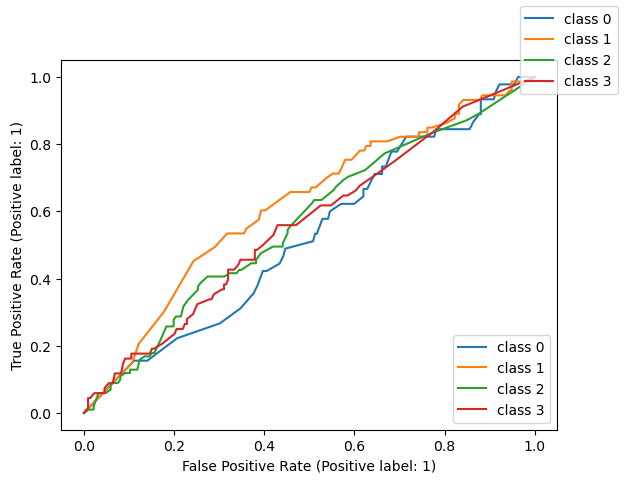

In [116]:
fig, ax = plt.subplots(1)
plt_colours = list(mcolors.TABLEAU_COLORS.keys())
predictions = pd.DataFrame(smf_mod.predict())
success_data = []
success_prediction = []
auc_vals = []
for i in range(0,4):
    success_data.append(test_mnlogit.regression_model_data.thread_size_bin_index.apply(assign_success_from_quartile, quartile_index=i))
    success_prediction.append(get_success_prediction_for_quartile(predictions, i))
    auc_vals.append(
        metrics.roc_auc_score(success_data[i], success_prediction[i])
    )

    metrics.RocCurveDisplay.from_predictions(success_data[i], success_prediction[i], ax=ax, label=f'class {i}', color=plt_colours[i])

fig.legend()

plt.show()

In [104]:
auc_vals

[0.5251606978879705,
 0.6187427986173345,
 0.5648887469392101,
 0.5611066344345957]

In [91]:
mean_auc = np.array(auc_vals).mean()

In [92]:
mean_auc

0.5674747194697777

In [119]:
predictions

,0,1,2,3
0,0.172577,0.376150,0.275047,0.176226
1,0.168025,0.310344,0.315226,0.206405
2,0.136378,0.152922,0.418284,0.292416
3,0.165021,0.284275,0.331590,0.219114
4,0.138206,0.158581,0.414391,0.288821
...,...,...,...,...
282,0.170287,0.335897,0.299435,0.194381
283,0.172577,0.376150,0.275047,0.176226
284,0.170287,0.335897,0.299435,0.194381
285,0.148144,0.193704,0.390563,0.267589


In [124]:
predicted_classes = predictions.idxmax(axis=1)
actual_classes = test_mnlogit.regression_model_data.thread_size_bin_index.reset_index(drop=True)

In [130]:
predicted_value_counts = (predicted_classes == actual_classes).value_counts()
predicted_value_counts

False    176
True     111
dtype: int64

In [137]:
predicted_value_counts.loc[True]/predicted_value_counts.sum()

0.3867595818815331

In [128]:
predicted_classes.unique()

array([1, 2], dtype=int64)

In [129]:
actual_classes.unique()

array([3, 0, 2, 1], dtype=int64)

In [140]:
modstring = "thread_size_bin_index ~ log_author_all_activity_count + activity_ratio + mean_author_sentiment_sign + mean_author_sentiment_magnitude"

In [141]:
smf_mod = smf.mnlogit(modstring, data=test_mnlogit.regression_model_data).fit()

Optimization terminated successfully.
         Current function value: 1.302015
         Iterations 5


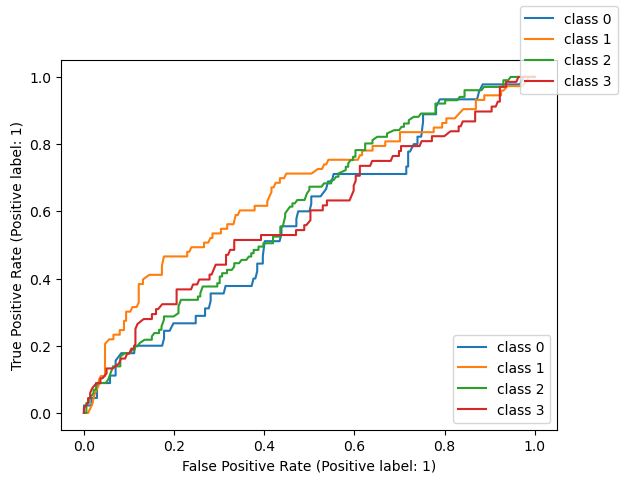

In [142]:
fig, ax = plt.subplots(1)
plt_colours = list(mcolors.TABLEAU_COLORS.keys())
predictions = pd.DataFrame(smf_mod.predict())
success_data = []
success_prediction = []
auc_vals = []
for i in range(0,4):
    success_data.append(test_mnlogit.regression_model_data.thread_size_bin_index.apply(assign_success_from_quartile, quartile_index=i))
    success_prediction.append(get_success_prediction_for_quartile(predictions, i))
    auc_vals.append(
        metrics.roc_auc_score(success_data[i], success_prediction[i])
    )

    metrics.RocCurveDisplay.from_predictions(success_data[i], success_prediction[i], ax=ax, label=f'class {i}', color=plt_colours[i])

fig.legend()

plt.show()

In [143]:
auc_vals

[0.5702020202020202,
 0.6573422097042633,
 0.6059831789630575,
 0.5827625570776256]

In [144]:
predicted_classes = predictions.idxmax(axis=1)
actual_classes = test_mnlogit.regression_model_data.thread_size_bin_index.reset_index(drop=True)
predicted_value_counts = (predicted_classes == actual_classes).value_counts()
predicted_value_counts.loc[True]/predicted_value_counts.sum()

0.4146341463414634

In [146]:
predicted_classes.unique()

array([1, 2, 3], dtype=int64)